# BigARTM new Python API.

## Example #1

This paper provides simple example of usage of new Python API. We will learn a model on the small dataset 'kos'.
Let's make necessary imports at first (notice that you should have BigARTM Python API installed in your environment):

In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt

import artm

The first step is to create a topic model. New API allows us to do it as a single line:

In [2]:
model = artm.ARTM(num_topics=15,
                  num_document_passes=10,
                  scores=[artm.PerplexityScore(name='PerplexityScore')],
                  regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-2.0)])

ARTM is an object contains all information about current topic model state. You're able to add regularizers and metrics directly in the constructor, as showen in this example.

First of all we need to create an object of BatchVectorizer class representing the library input data. According to existence of batches we create it using them or by parsing 'docword' and 'vocab' files in UCI format:

In [3]:
batch_vectorizer = None
if len(glob.glob('kos' + "/*.batch")) < 1:
    batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci', collection_name='kos', target_folder='kos')
else:
    batch_vectorizer = artm.BatchVectorizer(data_path='kos', data_format='batches')

Next step is to initilize model with collection dictionary. It means, that 
- Phi matrix 'pwt' will be created in appliance with number of tokens in dictionary and topics count in model
- This matrix will be filled with random numbers in (0, 1) and normalized

Note that this step is optional, because the model can be auto-initialized during fit_offline() / fit_online() call.

In [4]:
model.load_dictionary(dictionary_name='dictionary', dictionary_path='kos/dictionary')
model.initialize(dictionary_name='dictionary')

ARTM provides all model scores, that exists in BigARTM. If you have applied the score to the model, the model will save it's values on every update of Phi matrix. You can add regularizers and metrics after constructor call.

In order to control the quality of the model we will add two more scores to it:

In [5]:
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))

Also it is usefull to add basic regularizers to improve sparsity and variance of the topics (we will set some initial tau coeffitients for the regularizers, they can be changed in future)

In [6]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=100000.0))

Now let's try to learn the model in the offline mode (e.g. with one Phi update during one scan of the whole collection). We will invoke 5 scans:

In [7]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

Let's check the result of the first iteration of learning:

In [8]:
print 'Sparsity Phi:' + str(model.score_tracker['SparsityPhiScore'].last_value)
print 'Sparsity Theta:' + str(model.score_tracker['SparsityThetaScore'].last_value)

Sparsity Phi:0.420696978473
Sparsity Theta:0.703848396501


We can see, that sparsity levels of both Phi and Theta are too low. Let's increase (in modulus) the coefficients of regularization for sparsity regularizers:

In [9]:
model.regularizers['SparsePhi'].tau = -0.4
model.regularizers['SparseTheta'].tau = -3.0

Also it will be useful to add new score 'TopTokensScore'. It will allow us to see the most probable tokens in each topic

In [10]:
model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=5))

Next we will continue the learning of our model, 15 scans of the collection will be invoked now

In [11]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [12]:
print 'Sparsity Phi:' + str(model.score_tracker['SparsityPhiScore'].last_value)
print 'Sparsity Theta:' + str(model.score_tracker['SparsityThetaScore'].last_value)

Sparsity Phi:0.627425427165
Sparsity Theta:0.797329446064


The sparsity is still unsatisfactory. Let's try new tau coefficients and continue model learning:

In [13]:
model.regularizers['SparsePhi'].tau = -1.5
model.regularizers['SparseTheta'].tau = -5.0
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Let's plot perplexity and sparsity of the model to check it's quality:

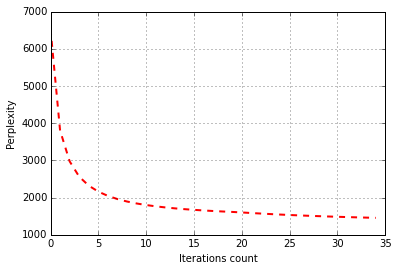

In [14]:
plt.plot(xrange(model.num_phi_updates), model.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

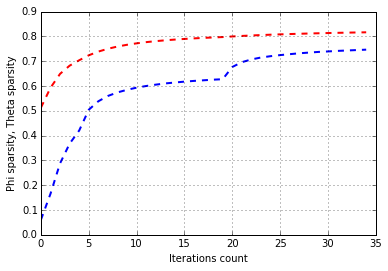

In [15]:
plt.plot(xrange(model.num_phi_updates), model.score_tracker['SparsityPhiScore'].value, 'b--',
         xrange(model.num_phi_updates), model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Phi sparsity, Theta sparsity')
plt.grid(True)
plt.show()

For such small collection the sparsity is enough. Next step is to visualize the top tokens:

In [16]:
for topic_name in model.topic_names:
    print topic_name + ': ',
    print model.score_tracker['TopTokensScore'].last_topic_info[topic_name].tokens

@topic_0:  [u'bush', u'rights', u'law', u'states', u'court']
@topic_1:  [u'iraq', u'iraqi', u'war', u'military', u'troops']
@topic_2:  [u'november', u'poll', u'electoral', u'governor', u'account']
@topic_3:  [u'senate', u'republican', u'carson', u'debate', u'coburn']
@topic_4:  [u'specter', u'toomey', u'hoeffel', u'workers', u'sessions']
@topic_5:  [u'dean', u'edwards', u'kerry', u'clark', u'primary']
@topic_6:  [u'state', u'race', u'senate', u'nader', u'candidate']
@topic_7:  [u'jobs', u'administration', u'years', u'billion', u'bush']
@topic_8:  [u'campaign', u'party', u'dean', u'democratic', u'unions']
@topic_9:  [u'house', u'republican', u'million', u'democrats', u'money']
@topic_10:  [u'november', u'voting', u'vote', u'account', u'electoral']
@topic_11:  [u'bush', u'iraq', u'war', u'administration', u'president']
@topic_12:  [u'bush', u'kerry', u'poll', u'percent', u'voters']
@topic_13:  [u'media', u'time', u'news', u'people', u'house']
@topic_14:  [u'bush', u'kerry', u'guard', u'g

Let's extract Phi matrix as pandas.DataFrame and print it (you can extract the parts of the Phi matrix using ARTM.get_phi() method if you need it):

In [17]:
print model.phi_

            @topic_0  @topic_1  @topic_2  @topic_3  @topic_4  @topic_5  \
aarp        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abandon     0.000493  0.000000  0.000000  0.000153  0.000000  0.000000   
abandoned   0.000000  0.000203  0.000000  0.000000  0.000000  0.000000   
abandoning  0.000024  0.000000  0.000000  0.000000  0.000000  0.000094   
abb         0.000456  0.000000  0.000000  0.000000  0.000000  0.000000   
abc         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abcs        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abdullah    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ability     0.000441  0.000000  0.000000  0.000000  0.000000  0.000203   
aboard      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abortion    0.002729  0.000000  0.000000  0.000251  0.000000  0.000000   
abortions   0.000425  0.000000  0.000000  0.000000  0.000000  0.000000   
abraham     0.000000  0.000000  0.0000

Our last step is to save the model with an ability to load it back:

In [18]:
model.save(filename='kos_artm_model')

In addition we can get the train Theta matrix of the collection:

In [19]:
theta_matrix = model.fit_transform()

ArtmModel.fit_transform() returns Theta matrix as pandas.DataFrame object. Let's print it:

In [20]:
print theta_matrix

           2001      2002  2003      2004      2005  2006      2007  2008  \
@topic_0      0  0.000000     0  0.000000  0.000000     0  0.000000     0   
@topic_1      0  0.000000     0  0.258220  0.000000     0  0.000000     0   
@topic_2      0  0.000000     0  0.000000  0.000000     1  0.000000     0   
@topic_3      0  0.000000     0  0.000000  0.000000     0  0.000000     0   
@topic_4      0  0.000000     0  0.000000  0.000000     0  0.000000     0   
@topic_5      0  0.661333     1  0.093464  0.858208     0  0.000000     1   
@topic_6      0  0.000000     0  0.000000  0.000000     0  0.505188     0   
@topic_7      0  0.000000     0  0.456537  0.000000     0  0.000000     0   
@topic_8      0  0.338667     0  0.000000  0.000000     0  0.313320     0   
@topic_9      1  0.000000     0  0.000000  0.000000     0  0.000000     0   
@topic_10     0  0.000000     0  0.000000  0.000000     0  0.000000     0   
@topic_11     0  0.000000     0  0.191780  0.000000     0  0.000000     0   

## Example #2

This is a second part of paper about basic usage of new Python API of BigARTM library. We will load back the model, saved in previous example, and proceed some new operations.

The first step is to create a new topic model:

In [21]:
new_model = artm.ARTM(num_topics=1, num_document_passes=1)

Second step is to add regularizers and scores. We'll restrict ourselves to one new score and two regularizers:

In [22]:
new_model.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
new_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=100000.0))

Now we will load 'kos_artm_model' file into library

In [23]:
new_model.load('kos_artm_model')

Note, that loaded model will overwrite several things in you ARTM object: number of topics and their names, Phi matrix. It also will reset all saved information about topic model scores values. 

Nevertheless the scores and the regularizers, applied to ARTM object earlier, won't change. In our case it is a 'TopicKernelScore' score and 'SparsePhi' and 'DecorrelatorPhi' regularizers.

Now let's continue model learning, but in online mode. It means that
- the number of passes through single document will increase
- Phi matrix updates will be proceed several times during one pass of the collection
- we need only one pass through the collection (but here we'll do 5, because the 'kos' collection is too small).

In [24]:
new_model.num_document_passes = 20
for i in xrange(5):
    new_model.fit_online(batch_vectorizer=batch_vectorizer, update_every=4)

'update_every' tells model the number of batches to be processed before next update of Phi.

Let's visualize topic kernel scores (average contrast and purity):

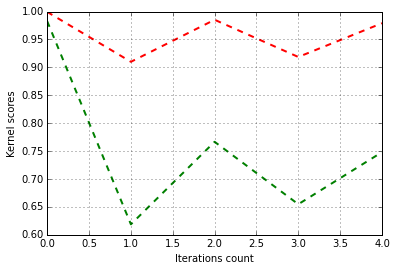

In [25]:
plt.plot(xrange(new_model.num_phi_updates), new_model.score_tracker['TopicKernelScore'].average_contrast, 'g--',
         xrange(new_model.num_phi_updates), new_model.score_tracker['TopicKernelScore'].average_purity, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Kernel scores')
plt.grid(True)
plt.show()

As we see, the further study of loaded model only downgraded the quality of the model.

Also we can see all information about each topic. For instance let's print topic kernel tokens for first topic:

In [26]:
print new_model.score_tracker['TopicKernelScore'].last_topic_info[new_model.topic_names[0]].tokens

[u'abandon', u'abb', u'abortion', u'abortions', u'action', u'activist', u'activists', u'acts', u'addition', u'address', u'advocate', u'affairs', u'affect', u'agenda', u'agree', u'agreed', u'allen', u'allowing', u'amendment', u'americas', u'angry', u'antiabortion', u'antigay', u'appeal', u'appealed', u'appealing', u'appeals', u'appears', u'apply', u'appointed', u'areas', u'arent', u'argue', u'argued', u'argument', u'arguments', u'arnold', u'asks', u'assault', u'backed', u'backers', u'ban', u'banning', u'bar', u'base', u'based', u'basic', u'bay', u'believes', u'benefit', u'benefits', u'bishops', u'black', u'blacks', u'blackwell', u'blocked', u'blue', u'body', u'born', u'budgets', u'burden', u'business', u'california', u'calling', u'cap', u'carter', u'catholic', u'catholics', u'ceo', u'checks', u'child', u'children', u'choices', u'christian', u'christians', u'church', u'circuit', u'circumstances', u'citizens', u'civil', u'class', u'clerks', u'closely', u'code', u'colleagues', u'college', 

If we have the batch with documents, that didn't take part in model learning, and we want to get Theta matrix for it, we can use 'find_theta' method:

In [27]:
test_batch_vectorizer = artm.BatchVectorizer(data_format='batches', data_path='kos_test', batches=['test_docs.batch'])
test_theta_matrix = new_model.transform(batch_vectorizer=test_batch_vectorizer)

ARTM.transform(), as ARTM.fit_transform(), returns Theta matrix as pandas.DataFrame object. Let's print it:

In [28]:
print test_theta_matrix

                   3001          3002          3003      3004          3005  \
@topic_0   9.710012e-02  2.171980e-02  9.249386e-02  0.136457  7.660387e-02   
@topic_1   7.978160e-02  0.000000e+00  5.726847e-02  0.000000  4.101091e-02   
@topic_2   0.000000e+00  5.166236e-02  0.000000e+00  0.037120  3.127101e-02   
@topic_3   2.007922e-02  1.173554e-02  6.994369e-16  0.052444  6.212134e-02   
@topic_4   0.000000e+00  0.000000e+00  0.000000e+00  0.009470  0.000000e+00   
@topic_5   0.000000e+00  0.000000e+00  1.264674e-02  0.000000  2.155282e-02   
@topic_6   0.000000e+00  3.562529e-16  5.564125e-02  0.013802  0.000000e+00   
@topic_7   7.599228e-07  1.435614e-02  2.989346e-02  0.013328  3.360545e-02   
@topic_8   1.528709e-09  0.000000e+00  1.465323e-14  0.031255  8.907447e-16   
@topic_9   4.936359e-02  4.631600e-01  2.596855e-07  0.117849  1.069804e-01   
@topic_10  2.909756e-09  0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
@topic_11  6.612843e-01  3.461375e-01  5.072102e-01 